# Homework on Panel Data

In [1]:
# !pip install panelsplit > /dev/null # installation of PanelSplit
# !pip install wbdata > /dev/null # installation of wbdata

In [2]:
from panelsplit import PanelSplit
import wbdata
import pandas as pd; import numpy as np

/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Reload the example dataframe:

In [3]:
import pandas as pd; import numpy as np

# Define indicators and countries of interest
indicators = {"NY.GDP.MKTP.CD": "GDP",  # Gross Domestic Product (current US$)
              "SP.POP.TOTL": "Population",  # Total population
              "FP.CPI.TOTL.ZG": "Inflation",     # Inflation, consumer prices (annual %)
              "NE.TRD.GNFS.ZS": "Trade_Balance"}    # Trade balance (% of GDP)

# Change!
# countries = ["USA", "GBR", "FRA", "DEU", "ESP"]  # Example countries: USA, UK, France, Germany

countries = ["USA", "BRA", "RUS", "IND", "CHN"]  # Example countries: USA, UK, France, Germany

features, target  = ['Population','Inflation','Trade_Balance'], 'GDP' # Define feature columns and target

# Fetch data from the World Bank API
df = wbdata.get_dataframe(indicators, country=countries).reset_index()
df['date'] = df.date.astype(int)

# Change!
# df = df.query('date > 2000 & date <= 2020')

df = df.query('date > 2003 & date <= 2023')

print('a sample of the data:')
display(df.sample(5))

print('summary statistics:')
print(df.describe())

a sample of the data:


,country,date,GDP,Population,Inflation,Trade_Balance
136,India,2015,2.103588e+12,1.328024e+09,4.906973,41.922914
274,United States,2005,1.303920e+13,2.955166e+08,3.392747,25.638557
206,Russian Federation,2009,1.222646e+12,1.427853e+08,11.647330,48.435061
196,Russian Federation,2019,1.693115e+12,1.454533e+08,4.470367,49.228754
65,China,2022,1.788178e+13,1.412175e+09,1.973576,38.351482


summary statistics:
              date           GDP    Population  Inflation  Trade_Balance
count   100.000000  1.000000e+02  1.000000e+02  98.000000     100.000000
mean   2013.500000  6.642993e+12  6.640843e+08   5.037839      39.333673
std       5.795331  7.194120e+12  5.522916e+08   3.261399      11.379128
min    2004.000000  5.910167e+11  1.427424e+08  -0.728165      22.105976
25%    2008.750000  1.674373e+12  1.916518e+08   2.635097      27.627500
50%    2013.500000  2.293633e+12  3.172231e+08   4.358355      39.140118
75%    2018.250000  1.249267e+13  1.319578e+09   6.697890      48.309407
max    2023.000000  2.772071e+13  1.438070e+09  15.534405      64.479191


Say we don't have all the data available- 10% of the features are missing at random.

In [4]:
# Change proportion of features that are missing:
# Choose different fractions

# for i, col in enumerate(df[features].columns):
#     df.loc[df.sample(frac=0.2, random_state=i).index, col] = np.nan

df.loc[df.sample(frac=0.1, random_state=1).index, features[0]] = np.nan
df.loc[df.sample(frac=0.12, random_state=2).index, features[1]] = np.nan
df.loc[df.sample(frac=0.15, random_state=3).index, features[2]] = np.nan

print('proportion of features that are missing:')
round(df[features].isna().mean(), 4)

proportion of features that are missing:


Population       0.10
Inflation        0.14
Trade_Balance    0.15
dtype: float64

We can use PanelSplit to apply imputation in a time-series fashion to fill in the missing data.

#### Initializing PanelSplit
- To initialize PanelSplit, we pass the time series to the periods argument.
- n_splits, gap, and test_size are all arguments used by [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to split up the time series.
- When we specify `plot=True`, a graph is displayed. This is a helpful visualization to understand what this particular instance of PanelSplit is doing. By reading this graph, we see that there are 19 folds or splits, that range from 2001 up to 2020. Train sets are marked in blue and test sets are marked in red.

#### `cross_val_fit_transform`
- PanelSplit's cross_val_fit_transform takes any object that can implement fit/transform (like a scaler or imputer). 
- It iteratively fits on the train and transforms the test for each fold. 
- By setting `include_test_in_fit = True`, we also include the test data during fitting for each fold.


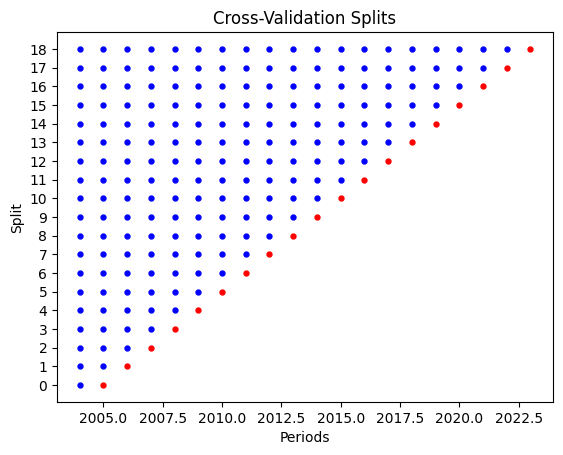

In [5]:
from sklearn.impute import SimpleImputer

# Change:

# n_splits = 2020-2001

n_splits = 2023-2004

panel_split = PanelSplit(periods=df.date, n_splits = n_splits, gap=0, test_size=1, plot=True)

df[features], fitted_imputers = panel_split.cross_val_fit_transform(
    SimpleImputer(missing_values=np.nan, strategy='mean'), df[features], include_test_in_fit=True
    )

The only observations which are still missing are in 2004. This is because that is the train set for first split.

In [6]:
df[df.isna().any(axis=1)]

,country,date,GDP,Population,Inflation,Trade_Balance
275,United States,2004,1.221720e+13,292805298.0,NaN,24.448057


We can go ahead and implement imputation for observations that take place in January of 2001

In [7]:
# Change!

# df.loc[df.date == 2001, features] = KNNImputer().fit_transform(df.loc[df.date == 2001, features])

df.loc[df.date == 2004, features] = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df.loc[df.date == 2004, features])

df.isna().sum()

country          0
date             0
GDP              0
Population       0
Inflation        0
Trade_Balance    0
dtype: int64

Now that all observations have all features, we can determine the best set of hyper-parameters to use.

#### Hyper-parameter search

Since PanelSplit is compatible with sklearn, we can use any sklearn hyper-parameter optimizer has takes cv as an argument.

Let's say that our validation period is 2010-2015 and our test period is 2016-2020.


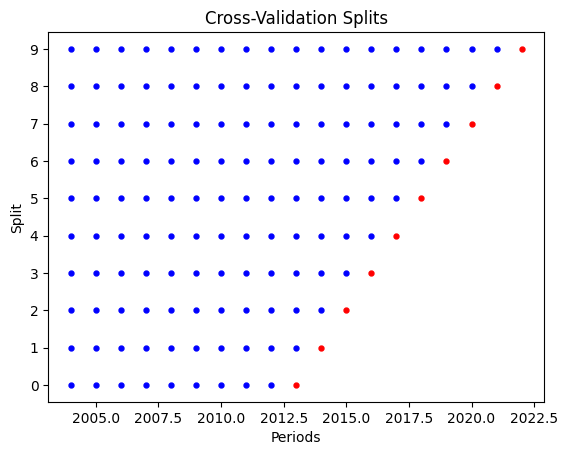

Fitting 10 folds for each of 36 candidates, totalling 360 fits


/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpen

GridSearch results:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaves,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004587,0.000917,0.001237,0.000318,2,5,3,10,"{'max_depth': 2, 'max_leaves': 5, 'min_child_w...",0.838003,0.893804,0.839375,0.898200,0.285971,0.736406,0.550655,-0.017471,0.286388,0.454042,0.576537,0.300710,1
1,0.003460,0.001208,0.001274,0.000597,2,5,5,10,"{'max_depth': 2, 'max_leaves': 5, 'min_child_w...",0.773361,0.815767,0.786393,0.883402,0.253756,0.795094,0.486003,-0.030466,0.283376,0.471693,0.551838,0.292167,4
2,0.002079,0.000051,0.000869,0.000062,2,5,7,10,"{'max_depth': 2, 'max_leaves': 5, 'min_child_w...",0.650415,0.816066,0.750610,0.872706,0.361264,0.790969,0.533366,-0.099181,0.278439,0.441202,0.539586,0.287255,7
3,0.002131,0.000121,0.000957,0.000219,2,10,3,10,"{'max_depth': 2, 'max_leaves': 10, 'min_child_...",0.838003,0.893804,0.839375,0.898200,0.285971,0.736406,0.550655,-0.017471,0.286388,0.454042,0.576537,0.300710,1
4,0.002363,0.000602,0.000910,0.000090,2,10,5,10,"{'max_depth': 2, 'max_leaves': 10, 'min_child_...",0.773361,0.815767,0.786393,0.883402,0.253756,0.795094,0.486003,-0.030466,0.283376,0.471693,0.551838,0.292167,4
5,0.002789,0.000657,0.001525,0.001147,2,10,7,10,"{'max_depth': 2, 'max_leaves': 10, 'min_child_...",0.650415,0.816066,0.750610,0.872706,0.361264,0.790969,0.533366,-0.099181,0.278439,0.441202,0.539586,0.287255,7
6,0.003667,0.002093,0.001436,0.001465,2,15,3,10,"{'max_depth': 2, 'max_leaves': 15, 'min_child_...",0.838003,0.893804,0.839375,0.898200,0.285971,0.736406,0.550655,-0.017471,0.286388,0.454042,0.576537,0.300710,1
7,0.003391,0.002283,0.001329,0.000805,2,15,5,10,"{'max_depth': 2, 'max_leaves': 15, 'min_child_...",0.773361,0.815767,0.786393,0.883402,0.253756,0.795094,0.486003,-0.030466,0.283376,0.471693,0.551838,0.292167,4
8,0.002185,0.000139,0.000887,0.000065,2,15,7,10,"{'max_depth': 2, 'max_leaves': 15, 'min_child_...",0.650415,0.816066,0.750610,0.872706,0.361264,0.790969,0.533366,-0.099181,0.278439,0.441202,0.539586,0.287255,7
9,0.002718,0.000790,0.000979,0.000197,3,5,3,10,"{'max_depth': 3, 'max_leaves': 5, 'min_child_w...",0.833834,0.916738,0.790914,0.867499,0.127631,0.843875,0.377157,-0.009675,0.143330,0.295023,0.518633,0.346746,22


In [8]:
from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# Change:

# validation_df = df.query('date < 2020')

validation_df = df.query('date < 2023')

# param_grid = {'max_depth': [3, 5], 'n_estimators': [10]}

param_grid = {'max_depth': [2, 3, 4, 5], 'min_child_weight': [3, 5, 7], 'max_leaves': [5, 10, 15], 'n_estimators': [10]}

panel_split = PanelSplit(validation_df.date, n_splits=10, gap=0, test_size=1, plot=True)

# Change:
# Choose different regressor: Use XGBoost regressor

# grid_search = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), param_grid=param_grid, cv = panel_split, n_jobs=-1, verbose = 1)

from xgboost import XGBRegressor

grid_search = GridSearchCV(XGBRegressor(n_jobs=-1, random_state=42), param_grid=param_grid, cv = panel_split, n_jobs=-1, verbose = 1)

grid_search.fit(validation_df[features], validation_df[target])

print('GridSearch results:')
display(pd.DataFrame(grid_search.cv_results_))

In [9]:
best_params = grid_search.best_params_
print(best_params)

{'max_depth': 2, 'max_leaves': 5, 'min_child_weight': 3, 'n_estimators': 10}


Now that we've determined what hyper-parameters to use, let's generate predictions in the test period.

#### `cross_val_fit_predict`
- PanelSplit's cross_val_fit_predict iteratively fits on the train and predicts the test for each fold
- Here are the arguments I use:
    - estimator: estimator object.
    - X: Features.
    - y: Target variable.
    - labels: pandas DataFrame containing labels for the target variable predicted by the model. The predicted target will be a new column added to this DataFrame.
    - prediction_method: The prediction method to use. It can be 'predict', 'predict_proba', or 'predict_log_proba'. Default is 'predict'.
    - y_pred_col: Column name for the predicted values. Default is None, in which case the name will be the name of y.name + 'pred'. If y does not have a name attribute, the name will be 'y_pred'.
    - n_jobs: The number of jobs to run in parallel

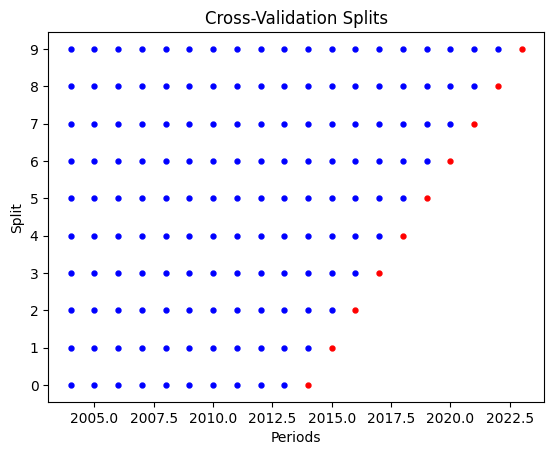

In [10]:
# Change:
# Choose 10 splits.
# panel_split = PanelSplit(df.date, n_splits=5, gap=0, test_size=1, plot=True)
panel_split = PanelSplit(df.date, n_splits=10, gap=0, test_size=1, plot=True)

result_df = panel_split.gen_test_labels(df[['country','date', 'GDP']])

# Change:
# result_df['GDP_pred'], models = panel_split.cross_val_fit_predict(RandomForestRegressor(**best_params),  X= df[features], y=df[target])

result_df['GDP_pred'], models = panel_split.cross_val_fit_predict(XGBRegressor(**best_params),  X= df[features], y=df[target])

The output of cross_val_fit_predict is a dataframe of predictions and fitted models. This is what the DataFrame looks like:

In [11]:
result_df

,country,date,GDP,GDP_pred
0,Brazil,2023,2.173666e+12,2.449404e+12
1,Brazil,2022,1.951924e+12,2.004509e+12
2,Brazil,2021,1.670647e+12,2.954244e+12
3,Brazil,2020,1.476107e+12,7.629595e+12
4,Brazil,2019,1.873288e+12,2.781719e+12
5,Brazil,2018,1.916934e+12,5.611246e+12
6,Brazil,2017,2.063515e+12,1.118915e+13
7,Brazil,2016,1.795693e+12,2.320120e+12
8,Brazil,2015,1.802212e+12,4.871310e+12
9,Brazil,2014,2.456044e+12,3.004410e+12


Let's assess performance:

In [12]:
# Change:
# Use three different metrics: RMSE, MAE, MAPE 
# from sklearn.metrics import mean_absolute_percentage_error
# print('MAPE:', round(mean_absolute_percentage_error(result_df.GDP, result_df.GDP_pred),2))

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print('RMSE:', round(np.sqrt(mean_squared_error(result_df.GDP, result_df.GDP_pred))/10**12,2))
print('MAE:', round(mean_absolute_error(result_df.GDP, result_df.GDP_pred)/10**12,2))
print('MAPE:', round(mean_absolute_percentage_error(result_df.GDP, result_df.GDP_pred),2))

RMSE: 5.63
MAE: 3.84
MAPE: 0.85


## Multiple Snapshots/Updated Values

There are also instances where you might want to keep observations seperate between folds, for example when scaling features. 

In this case, it is recommended that you use `cross_val_fit_predict` with a Pipeline object.

However, in case you need to manually implement something where observations must be handled differently across folds, PanelSplit's `gen_snapshots` converts a single df to multiple snapshots of that dataframe.

In [13]:
# Change:
# panel_split = PanelSplit(df.date, n_splits = (2020 - 2010), test_size=1)

panel_split = PanelSplit(df.date, n_splits = (2023 - 2013), test_size=1)

snapshot_df = panel_split.gen_snapshots(df, period_col = 'date')
print('2 new columns are created: split and snapshot_period:')
display(snapshot_df)
print(f'before gen_snapshot:{df.shape} after gen_snapshot:{snapshot_df.shape}')

2 new columns are created: split and snapshot_period:


,country,date,GDP,Population,Inflation,Trade_Balance,split,snapshot_period
9,Brazil,2014,2.456044e+12,200085127.0,6.329040,42.795067,0,2014
10,Brazil,2013,2.472820e+12,198478299.0,6.204311,25.785957,0,2014
11,Brazil,2012,2.465228e+12,196876111.0,5.403499,25.114274,0,2014
12,Brazil,2011,2.616156e+12,195284734.0,6.636450,23.934405,0,2014
13,Brazil,2010,2.208838e+12,193701929.0,5.906885,22.772178,0,2014
...,...,...,...,...,...,...,...,...
271,United States,2008,1.476986e+13,304093966.0,3.839100,29.867788,9,2023
272,United States,2007,1.447423e+13,301231207.0,2.852672,44.331051,9,2023
273,United States,2006,1.381558e+13,298379912.0,3.225944,43.969694,9,2023
274,United States,2005,1.303920e+13,295516599.0,3.392747,41.543501,9,2023


before gen_snapshot:(100, 6) after gen_snapshot:(775, 8)


Let's scale our data using `cross_val_fit_transform`. Here each snapshot is scaled separately. We also specify `transform_train=True`, thereby also transforming the training set for each fold.

In [14]:
# Change:
# Use MinMaxScaler instead of StandardScaler
# from sklearn.preprocessing import StandardScaler
# panel_split = PanelSplit(periods = snapshot_df.date, snapshots = snapshot_df.snapshot_period, n_splits = (2020 - 2010)) # notice the usage of the snapshots argument
# snapshot_df[features], scalers = panel_split.cross_val_fit_transform(StandardScaler(), X=snapshot_df[features], transform_train=True) # transform_train transforms the training set for each fold
# display(snapshot_df)

from sklearn.preprocessing import MinMaxScaler
panel_split = PanelSplit(periods = snapshot_df.date, snapshots = snapshot_df.snapshot_period, n_splits = (2023 - 2013)) # notice the usage of the snapshots argument
snapshot_df[features], scalers = panel_split.cross_val_fit_transform(MinMaxScaler(), X=snapshot_df[features], transform_train=True) # transform_train transforms the training set for each fold
display(snapshot_df)


,country,date,GDP,Population,Inflation,Trade_Balance,split,snapshot_period
9,Brazil,2014,2.456044e+12,0.046983,0.475587,0.488259,0,2014
10,Brazil,2013,2.472820e+12,0.045667,0.467182,0.086847,0,2014
11,Brazil,2012,2.465228e+12,0.044354,0.413215,0.070995,0,2014
12,Brazil,2011,2.616156e+12,0.043050,0.496304,0.043151,0,2014
13,Brazil,2010,2.208838e+12,0.041753,0.447138,0.015722,0,2014
...,...,...,...,...,...,...,...,...
271,United States,2008,1.476986e+13,0.125792,0.280845,0.183177,9,2023
272,United States,2007,1.447423e+13,0.123561,0.220189,0.524508,9,2023
273,United States,2006,1.381558e+13,0.121338,0.243142,0.515980,9,2023
274,United States,2005,1.303920e+13,0.119105,0.253399,0.458722,9,2023


# Additional Instructions:

- Go on to hyper-parameter tune and `cross_val_fit_predict` using the last **PanelSplit** object and **snapshot_df** dataframe in almost the same way you did before. 

- Print the new resulting dataframe **result_df** for the best fit parameters.

- Assess the performance again by calaculating the RMSE on the hold-out dataset.

- Note: In this case you need to specify the snapshots argument.

In [15]:
# from sklearn.model_selection import GridSearchCV

# # validation_df = snapshot_df.query('date < 2023')
# validation_df = snapshot_df

# param_grid = {'max_depth': [2, 3, 4, 5], 'min_child_weight': [3, 5, 7], 'max_leaves': [5, 10, 15], 'n_estimators': [10]}

# panel_split = PanelSplit(validation_df.date, n_splits=10, gap=0, test_size=1, plot=True, snapshots = validation_df.snapshot_period)

# from xgboost import XGBRegressor

# grid_search = GridSearchCV(XGBRegressor(n_jobs=-1, random_state=42), param_grid=param_grid, cv = panel_split, n_jobs=-1, verbose = 1)

# grid_search.fit(validation_df[features], validation_df[target])

# print('GridSearch results:')
# display(pd.DataFrame(grid_search.cv_results_))

In [16]:
# grid_search.cv_results_

In [17]:
# best_params = grid_search.best_params_
# print(best_params)

In [18]:
# result_df = panel_split.gen_test_labels(snapshot_df[['country', 'date', 'GDP']])

# result_df['GDP_pred'], models = panel_split.cross_val_fit_predict(XGBRegressor(**best_params),  X=snapshot_df[features], y=snapshot_df[target])


In [19]:
# result_df

In [20]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# print('RMSE:', round(np.sqrt(mean_squared_error(result_df.GDP, result_df.GDP_pred))/10**12,2))
# print('MAE:', round(mean_absolute_error(result_df.GDP, result_df.GDP_pred)/10**12,2))
# print('MAPE:', round(mean_absolute_percentage_error(result_df.GDP, result_df.GDP_pred),2))

# Submission Instructions:

- Go to the **Assessments** tab in iCollege and click on **Assignments.** Submit your solution under the **Homework 3** category.

- Report your values for **RMSE, MAE and MAPE** for your model performnace in the Homework submission field in iCollege.

- Attach this **executed (!)** Jupyter notebook and submit with your response above in iCollege.